In [1]:
import os
import hyperspy.api as hs
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import zarr
from PIL import Image
from squircle import Squircle

def absoluteFilePaths(directory:str):
    # Credits: https://stackoverflow.com/questions/9816816/get-absolute-paths-of-all-files-in-a-directory
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))


DATA_DIRECTORY = "/cluster/projects/itea_lille-nv-fys/TFY4330_nanotools/Grp11"
ZSPY_FILES_DIRECTORY = "data/zspy"

names_with_magnetism = []

dm3: dict[str, str] = {}
hdr: dict[str, str] = {}
mib: dict[str, str] = {}

for filepath in absoluteFilePaths(DATA_DIRECTORY):
    file = filepath.split("/")[-1].split(".")
    (name, file_extension) = file[0], file[-1]

    if file_extension == "mib":
        mib[name] = filepath
        names_with_magnetism.append(name)
    elif file_extension == "hdr":
        hdr[name] = filepath
    elif file_extension == "dm3":
        dm3[name] = filepath

os.makedirs(ZSPY_FILES_DIRECTORY, exist_ok=True)

name_to_bitmap = {
    "...":"bitmaps/bitmap-size-[200 200 260 260]nm.bmp",
    "...":"bitmaps/bitmap-size-[320 320 380 380]nm.bmp",
    "...":"bitmaps/bitmap-size-[440 440 500 500]nm.bmp",
}

names_with_magnetism.sort()

if "008" in names_with_magnetism:
    names_with_magnetism.remove("008") # Remove magnetic compass


In [2]:
%matplotlib widget
from pathlib import Path
import os
import hyperspy.api as hs


stem_folder = Path("data/stem-images")

os.makedirs(str(stem_folder), exist_ok=True)

for name in names_with_magnetism:
    s = hs.load(dm3[name])
    fig, ax = plt.subplots()
    cax = ax.imshow(s.data, cmap="gray", vmin=0, vmax=255)

    scale = s.axes_manager[0].scale
    #print(f"name:{name}, scale:{round(scale, 4)}")
    
    fig.savefig(f"stem-images/{name}-stem.png")

In [3]:
%matplotlib inline
import pyxem

def get_magnetic_data(name) -> pyxem.signals.BeamShift:
    s = hs.load(dm3[name])
    
    filepath = Path(ZSPY_FILES_DIRECTORY).joinpath(f"{name}.zspy")
    if not filepath.exists():
        s_4d = hs.load(mib[name], lazy=True, navigation_shape=(s.axes_manager[0].size + 1, s.axes_manager[1].size))
        s_4d_crop = s_4d.inav[:-1]
    
        for i in range(2):
            s_4d_crop.axes_manager[i].scale = s.axes_manager[i].scale
            s_4d_crop.axes_manager[i].unit = s.axes_manager[i].units
    
        s_4d_crop.axes_manager[0].name = "Probe x"
        s_4d_crop.axes_manager[1].name = "Probe y"
        s_4d_crop.axes_manager[2].name = "Diffraction x"
        s_4d_crop.axes_manager[3].name = "Diffraction y"
    
        store = zarr.ZipStore(str(filepath))
        s_4d_crop.save(store, chunks=(64,64,64,64))
    
    s_magnetic = hs.load(str(filepath), lazy=True)
    s_magnetic_sum = s_magnetic.sum(axis=(-1,-2))
    s_magnetic_nav = s_magnetic_sum.transpose
    s_magnetic.navigator = s_magnetic_nav
    
    s_magnetic_bs = s_magnetic.get_direct_beam_position(method="center_of_mass")
    s_magnetic_bs.compute()
    #s_magnetic_bs.plot()
    
    s_magnetic_bs_lp = s_magnetic_bs.get_linear_plane()
    
    s_magnetic_bs_corr = s_magnetic_bs - s_magnetic_bs_lp

    return s_magnetic_bs_corr

Figures for 002


  0%|          | 0/225 [00:00<?, ?it/s]

/tmp/ipykernel_875445/2353891.py:241: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Figures for 003


  0%|          | 0/225 [00:00<?, ?it/s]

Figures for 004


  0%|          | 0/225 [00:00<?, ?it/s]

Figures for 005


  0%|          | 0/225 [00:00<?, ?it/s]

Figures for 006


  0%|          | 0/225 [00:00<?, ?it/s]

Figures for 007


  0%|          | 0/225 [00:00<?, ?it/s]

Figures for 009


  0%|          | 0/225 [00:00<?, ?it/s]

KeyboardInterrupt: 

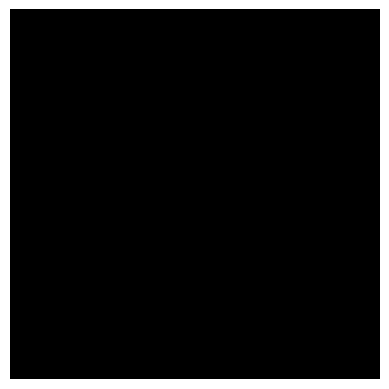

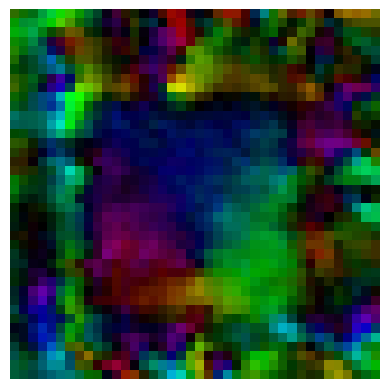

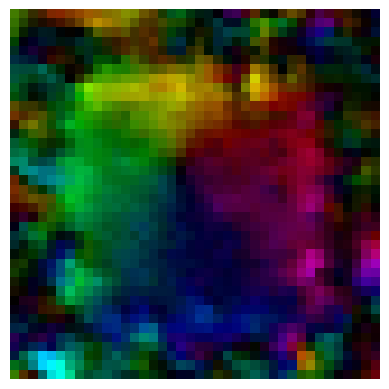

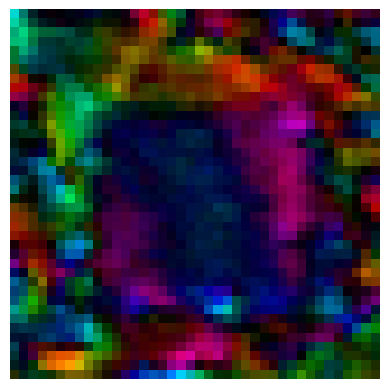

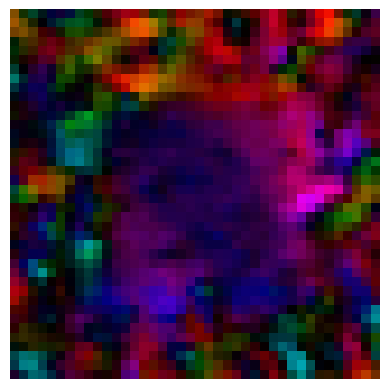

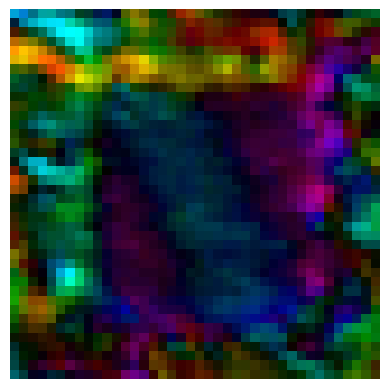

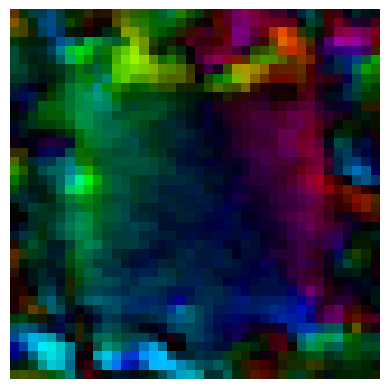

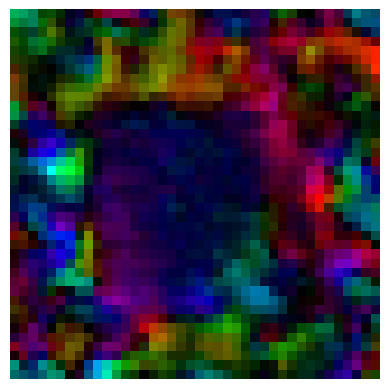

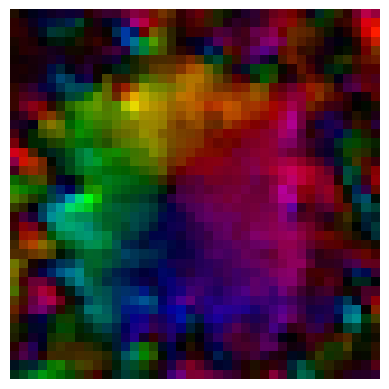

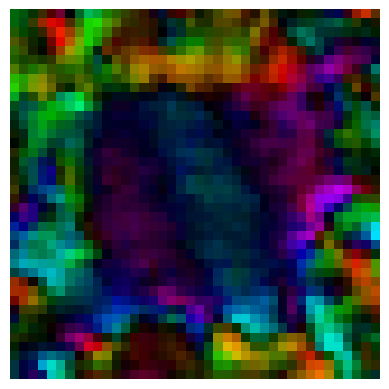

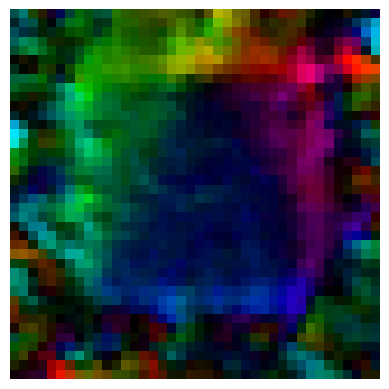

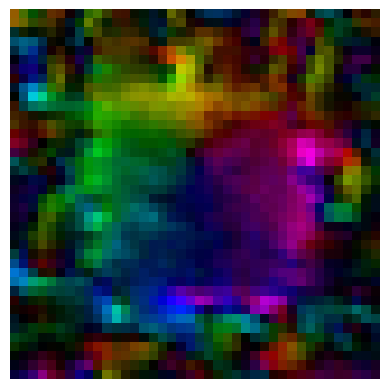

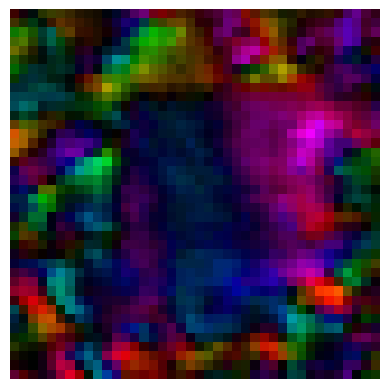

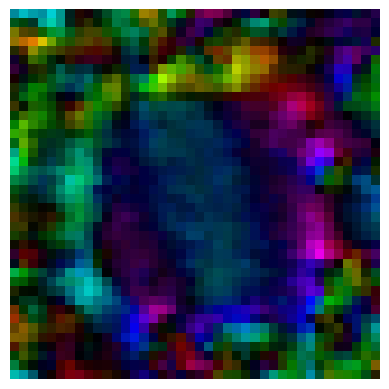

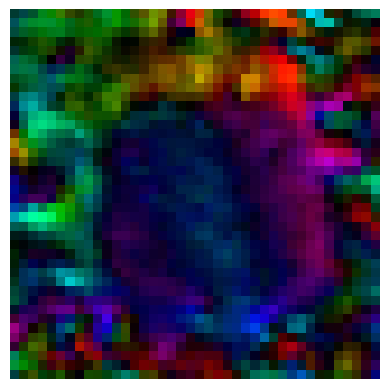

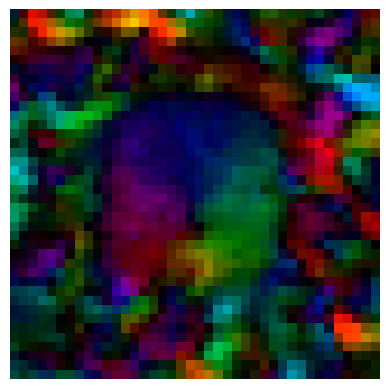

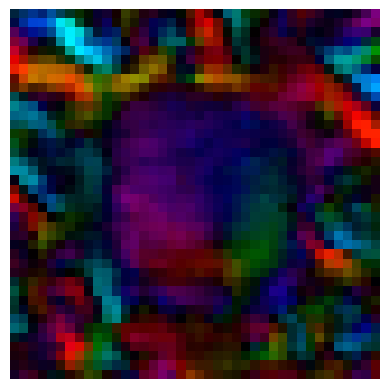

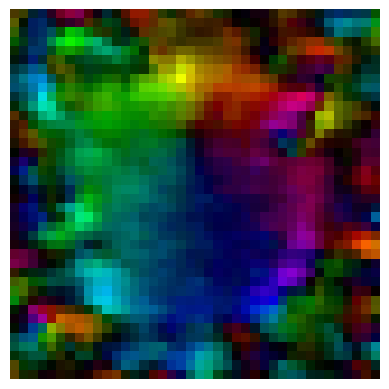

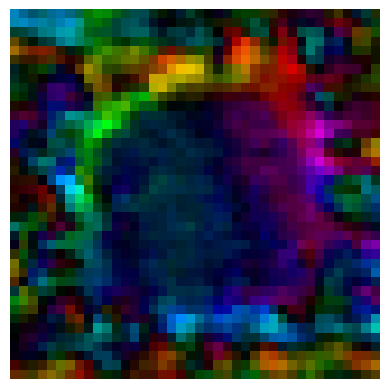

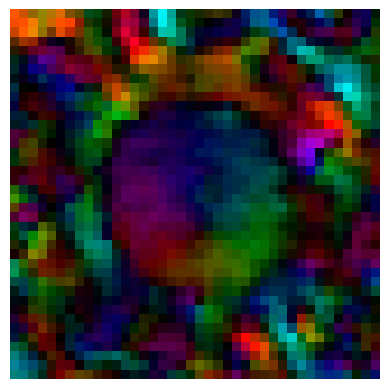

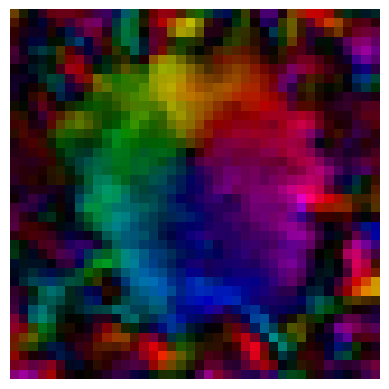

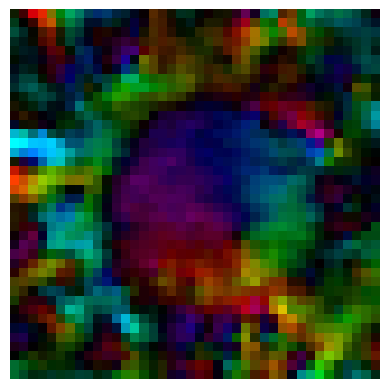

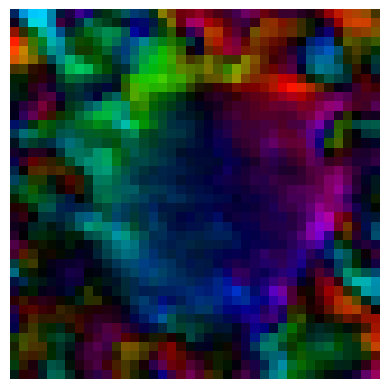

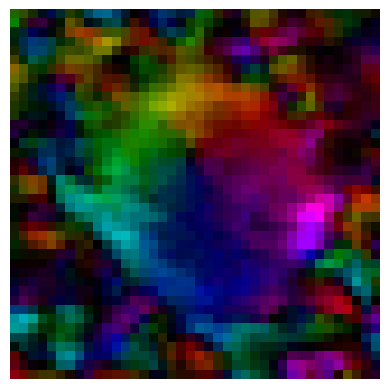

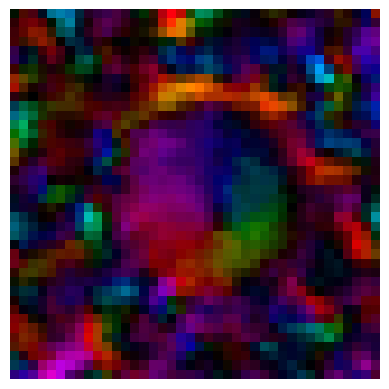

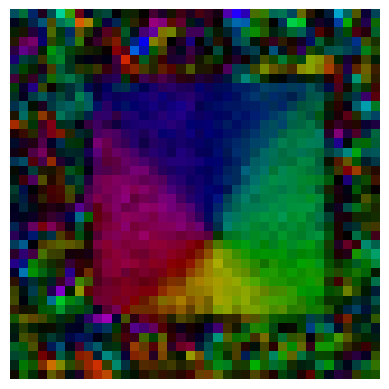

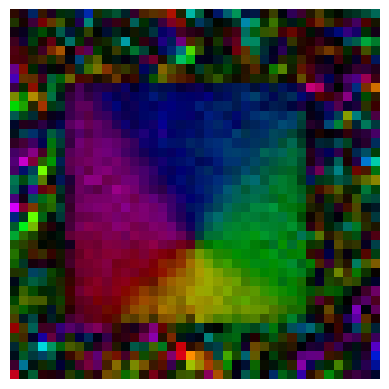

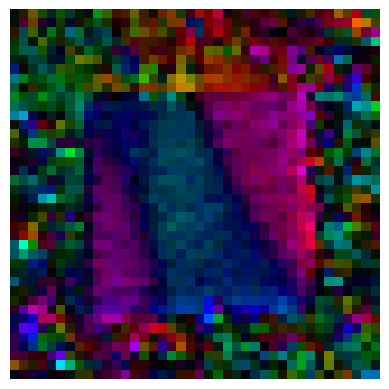

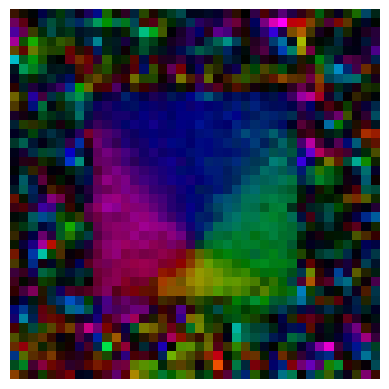

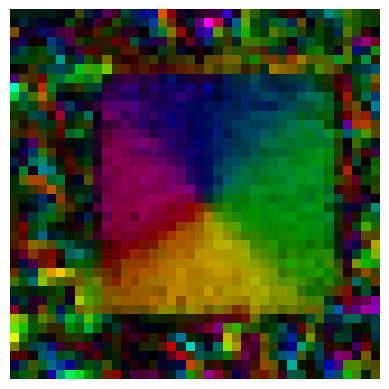

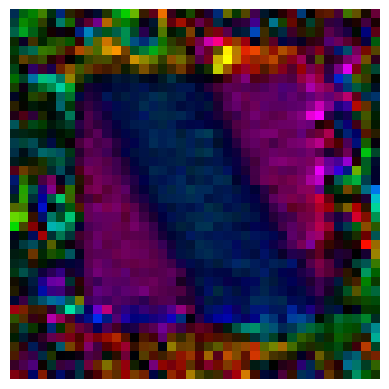

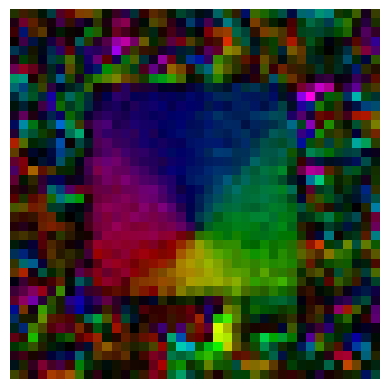

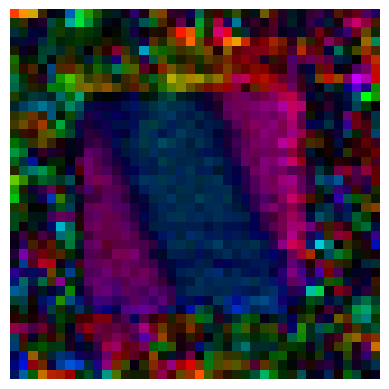

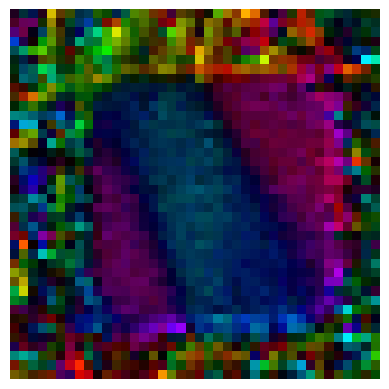

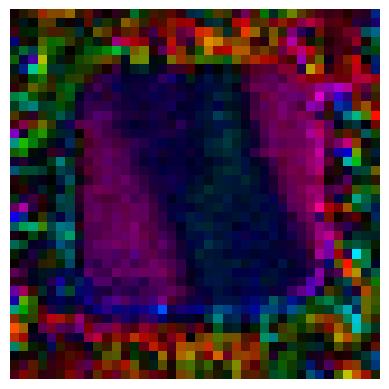

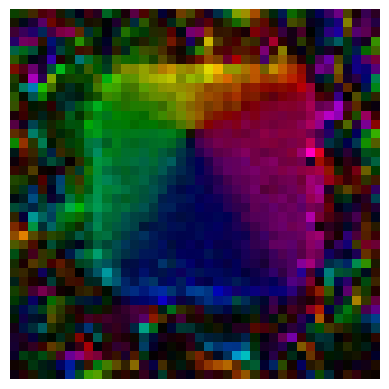

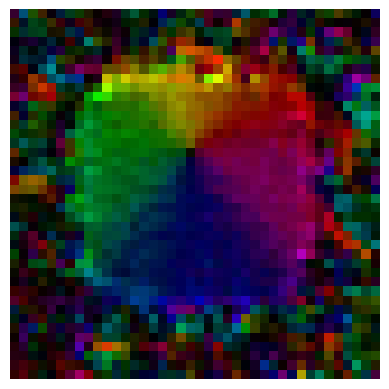

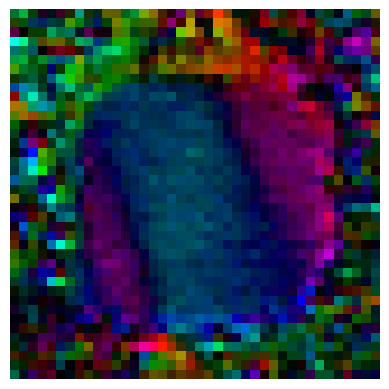

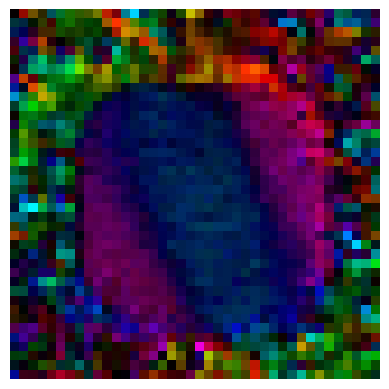

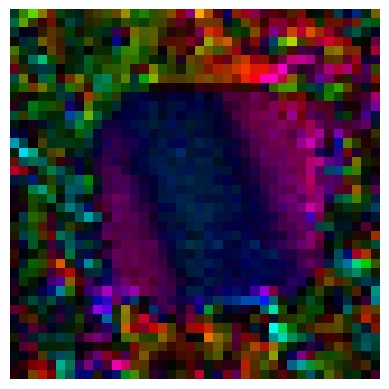

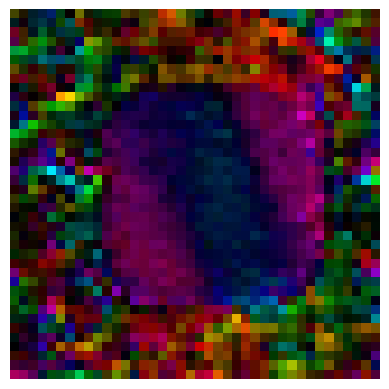

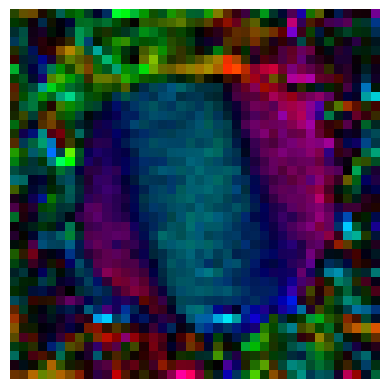

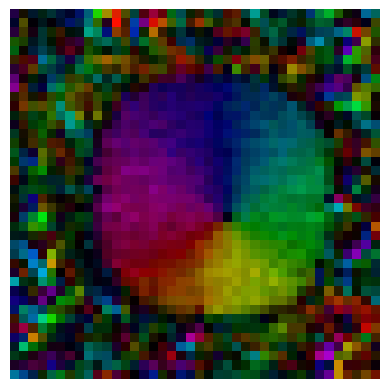

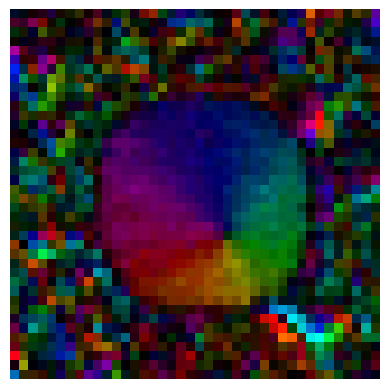

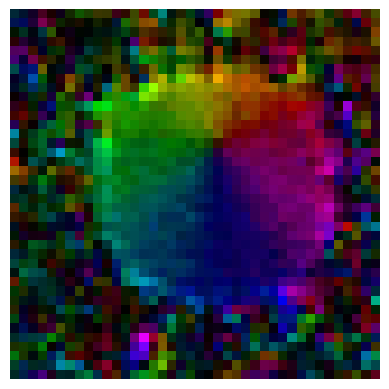

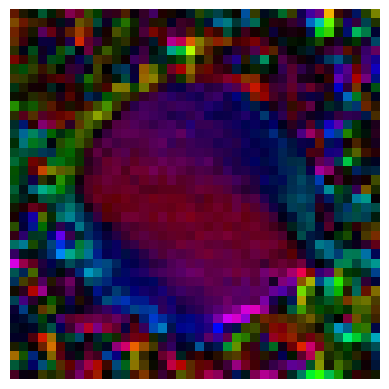

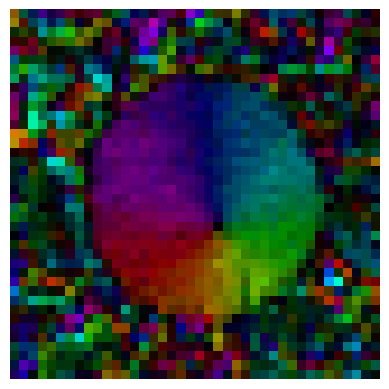

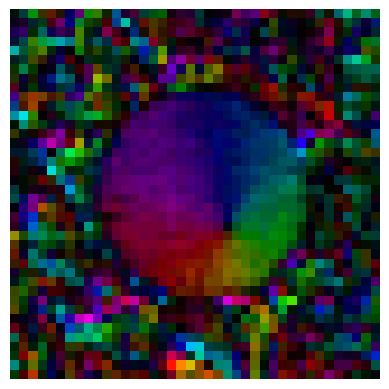

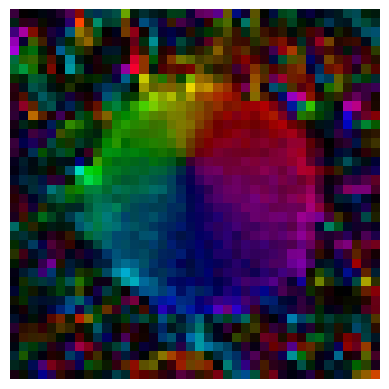

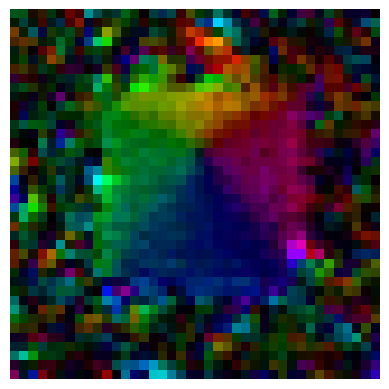

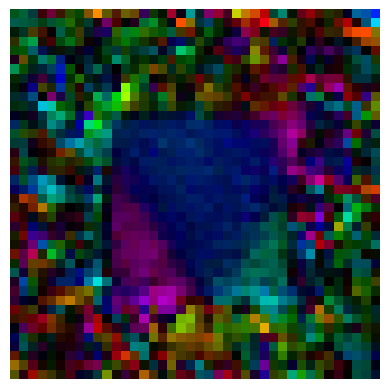

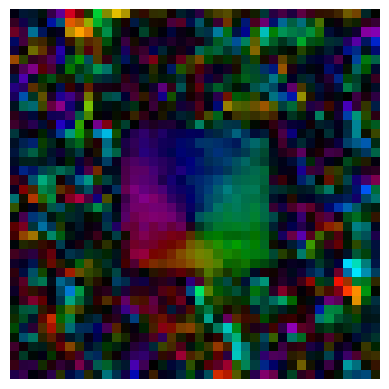

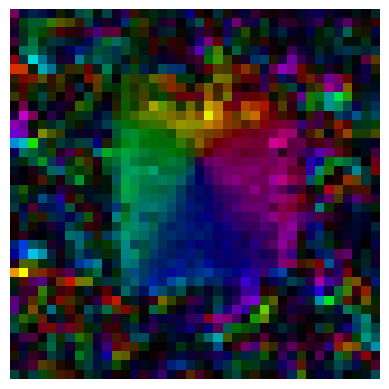

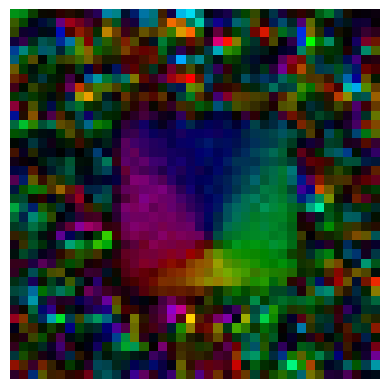

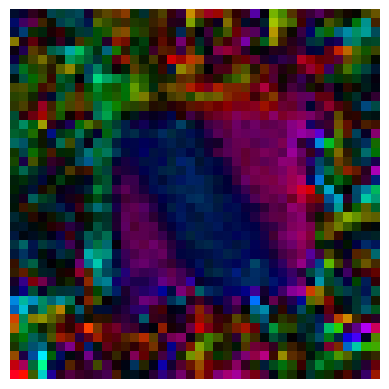

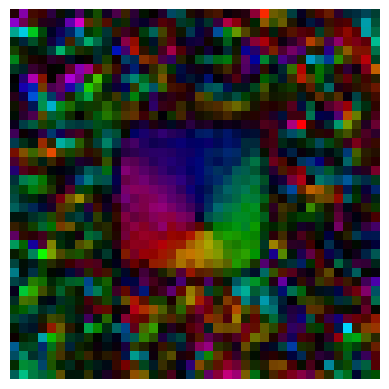

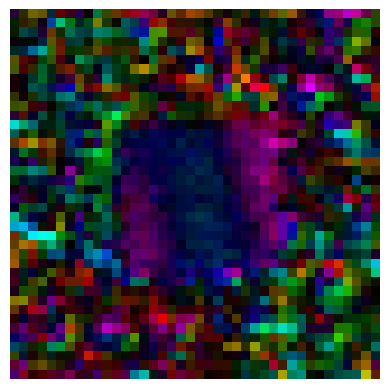

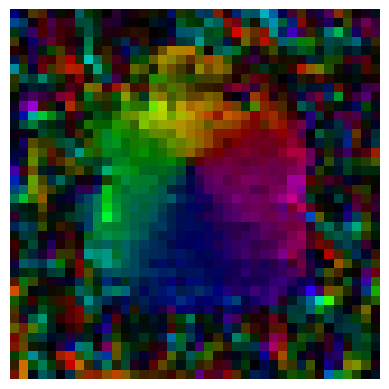

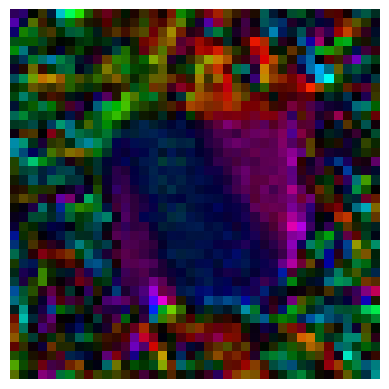

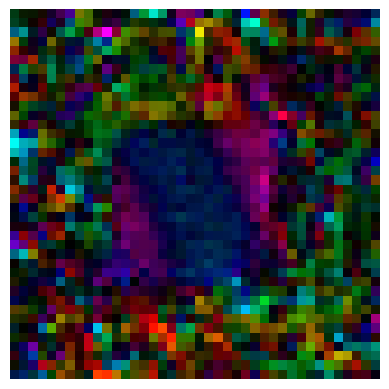

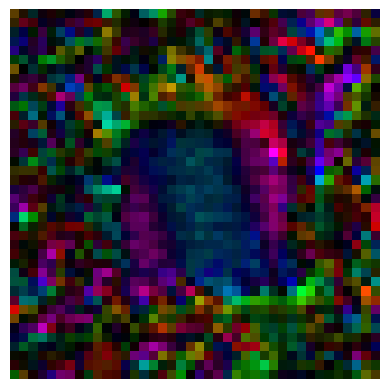

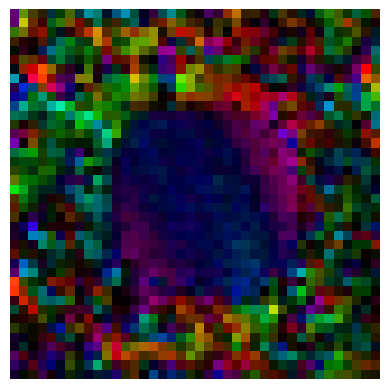

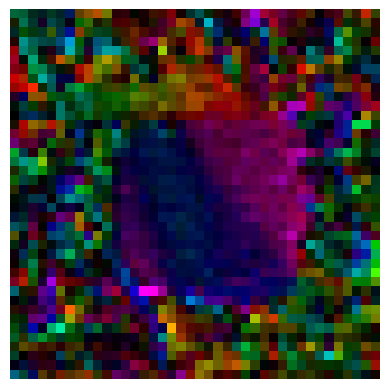

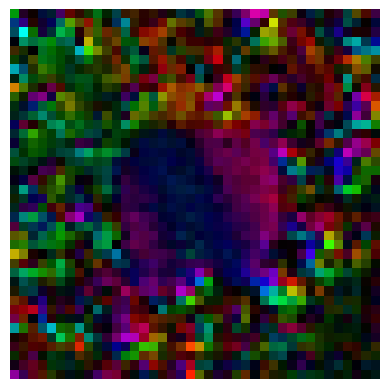

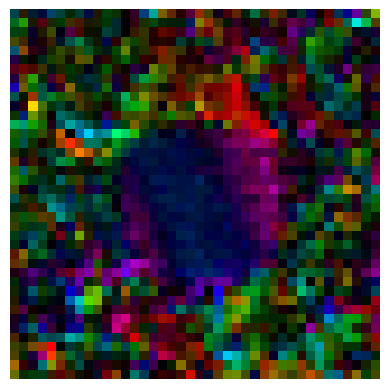

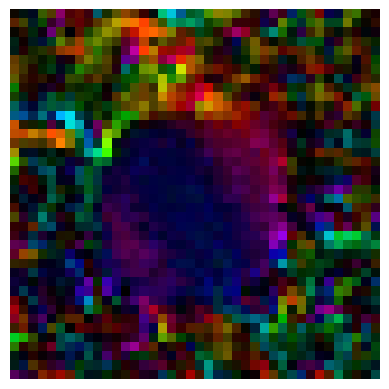

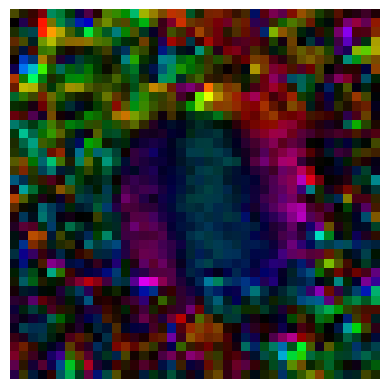

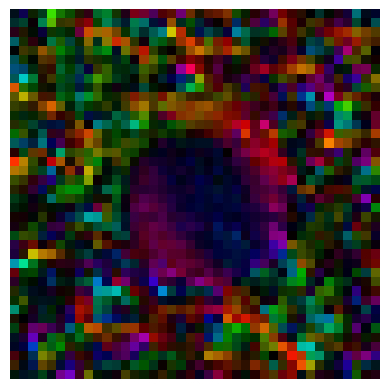

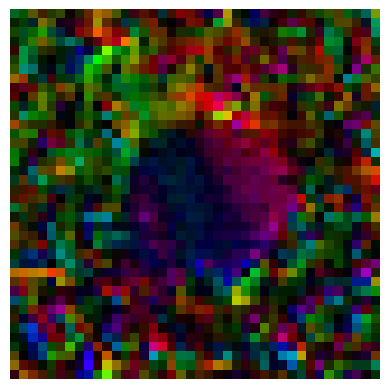

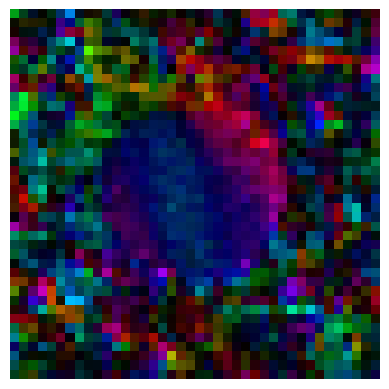

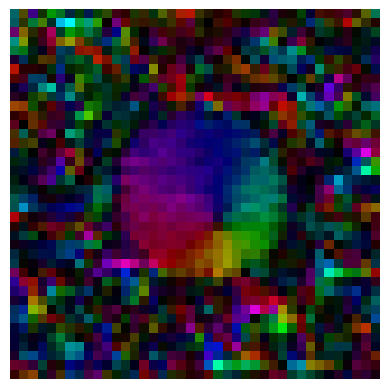

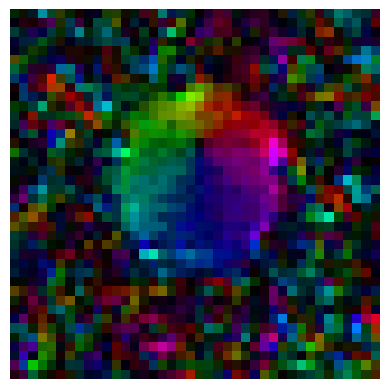

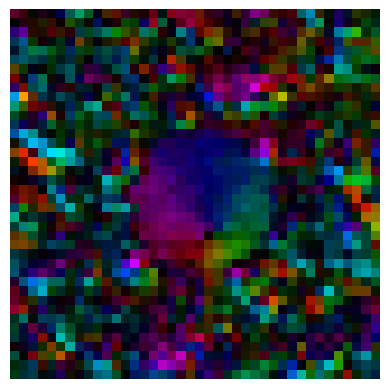

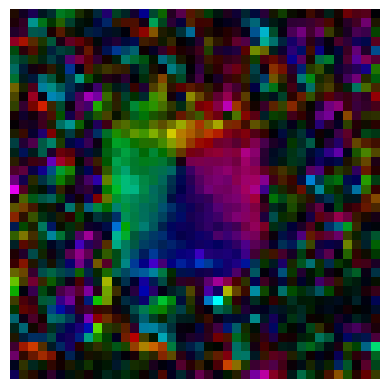

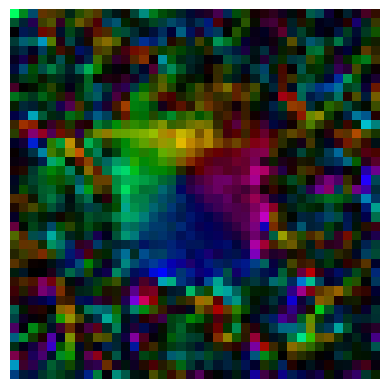

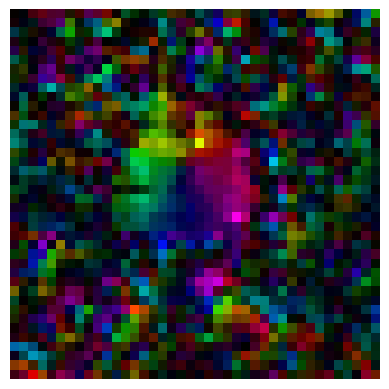

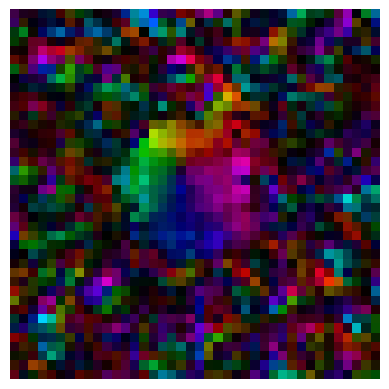

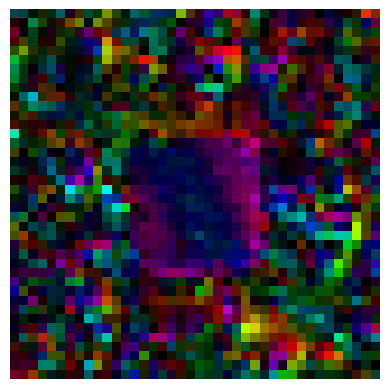

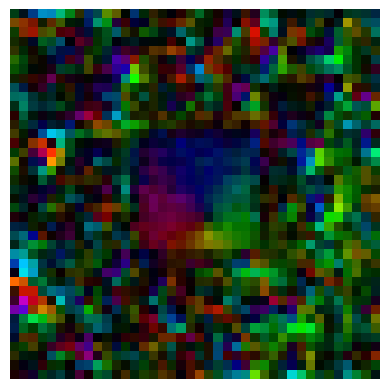

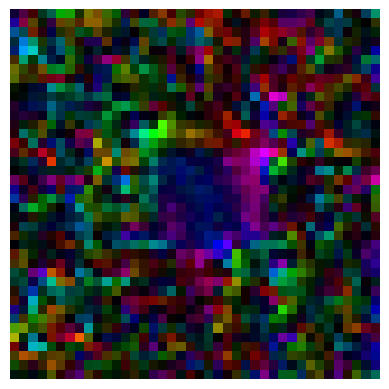

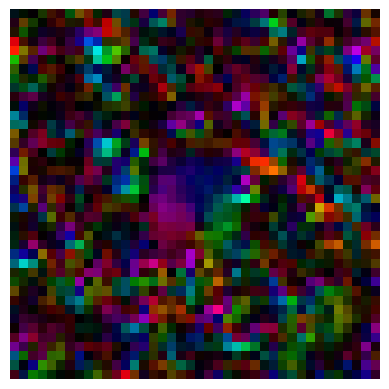

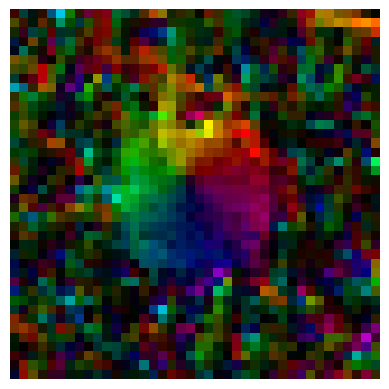

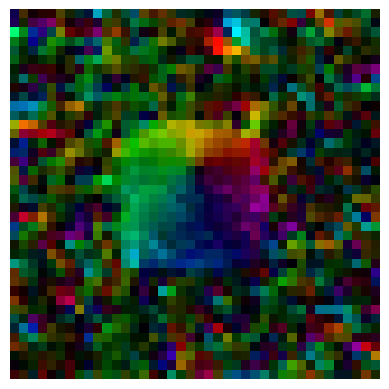

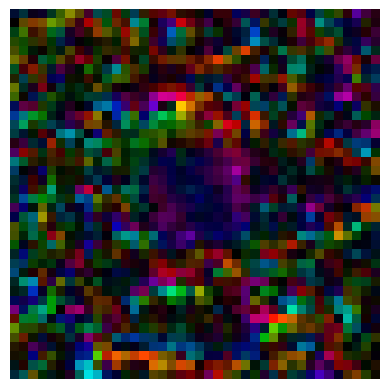

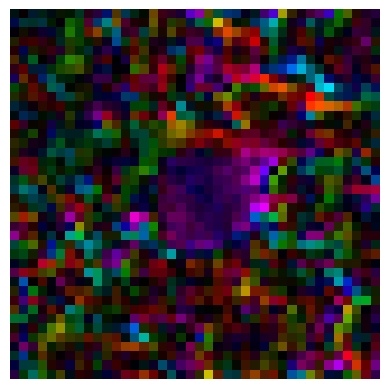

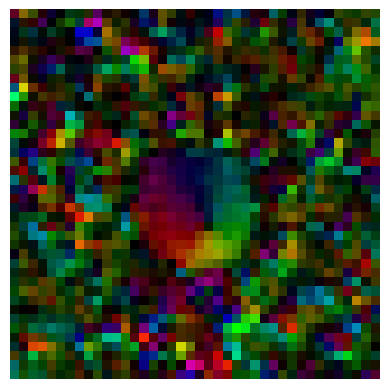

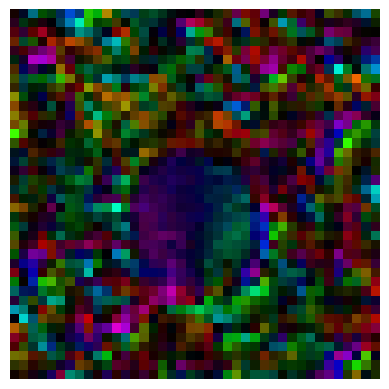

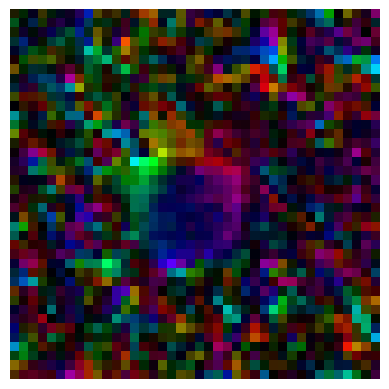

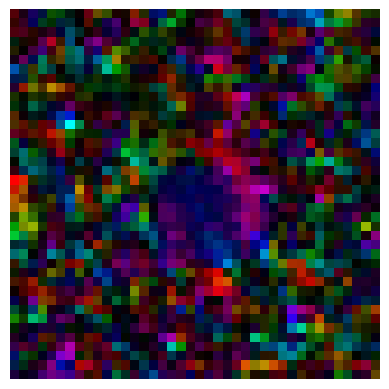

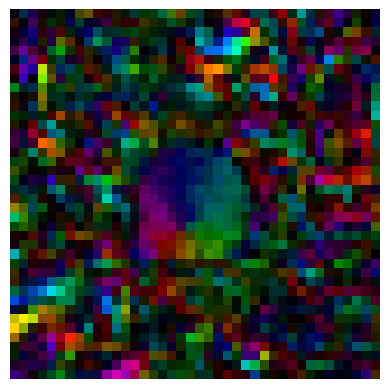

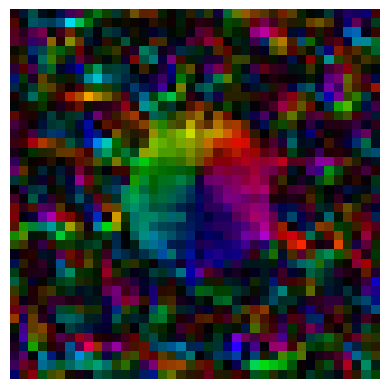

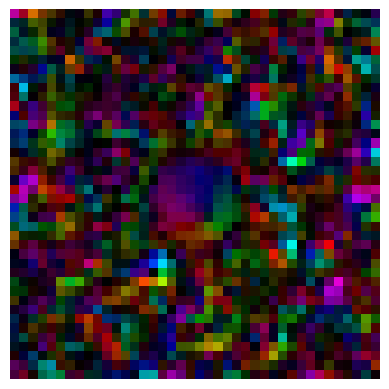

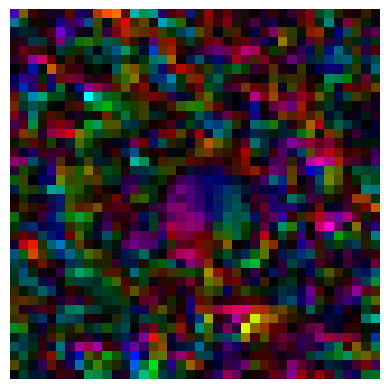

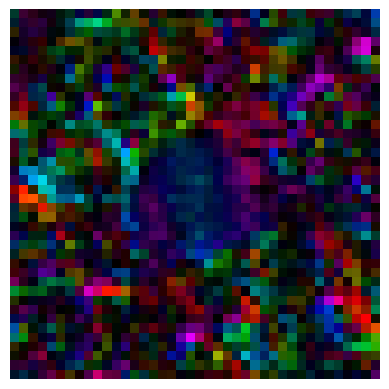

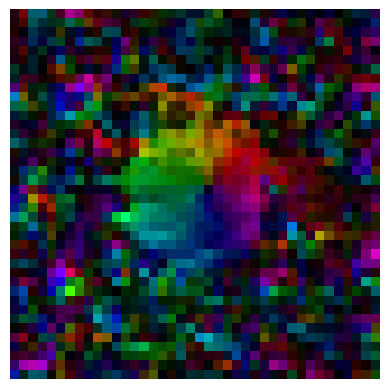

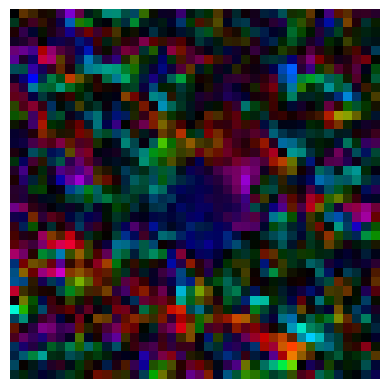

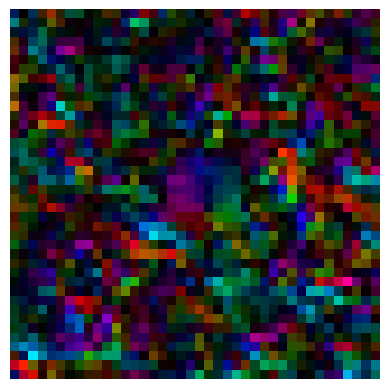

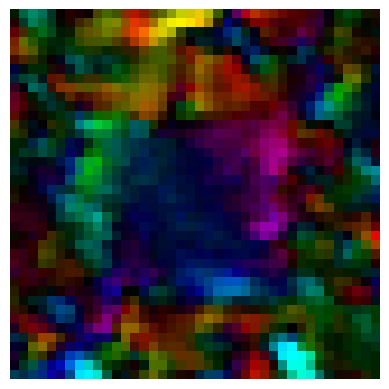

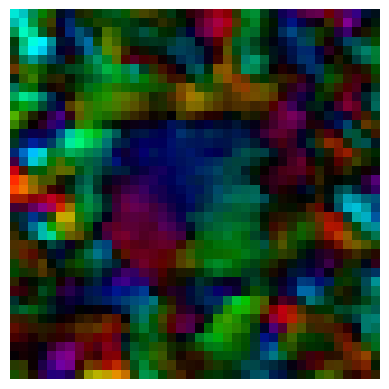

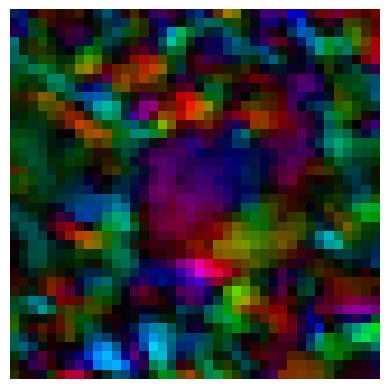

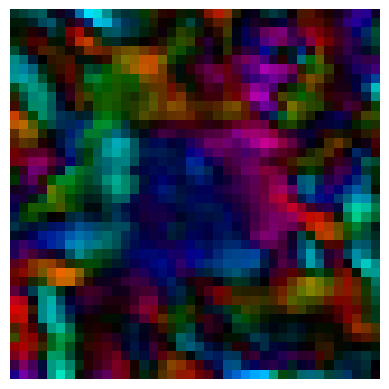

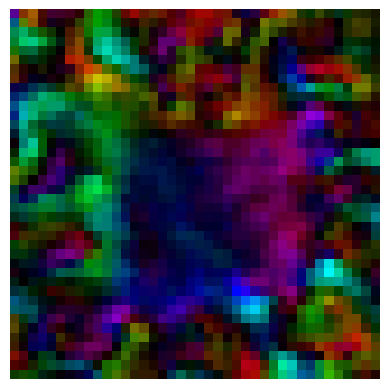

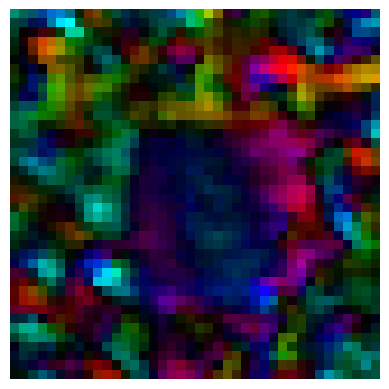

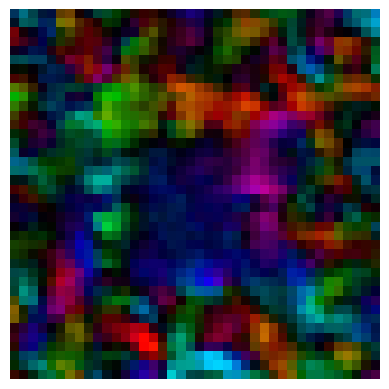

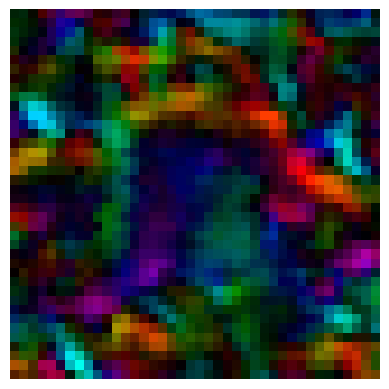

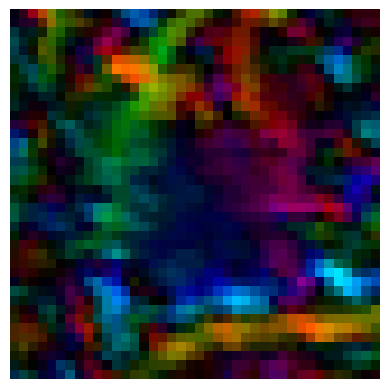

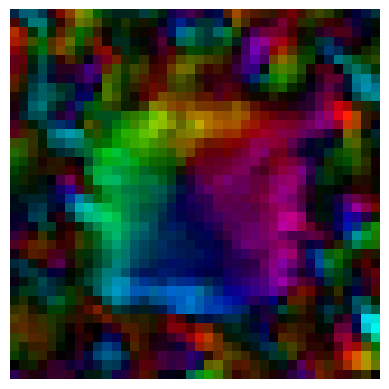

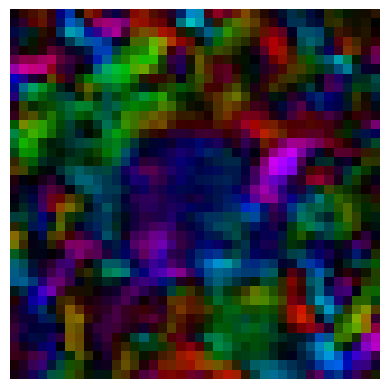

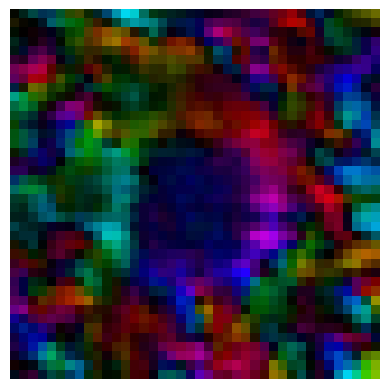

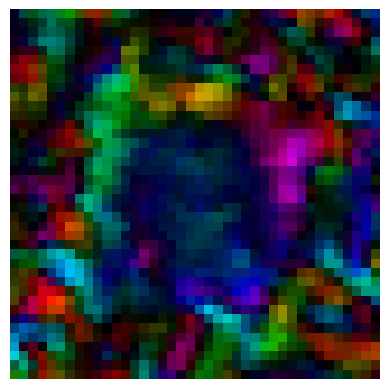

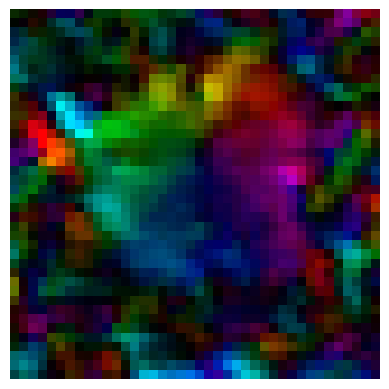

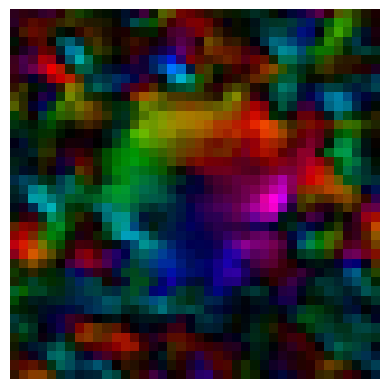

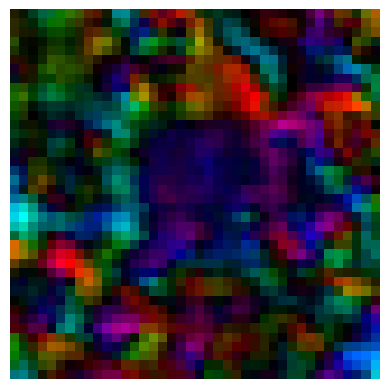

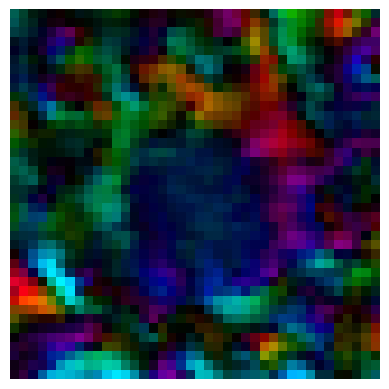

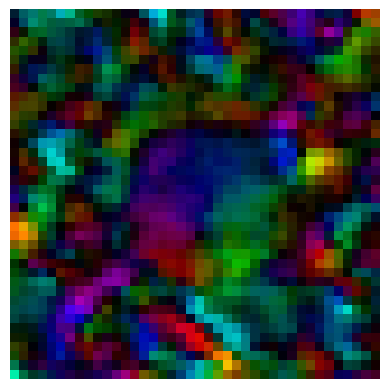

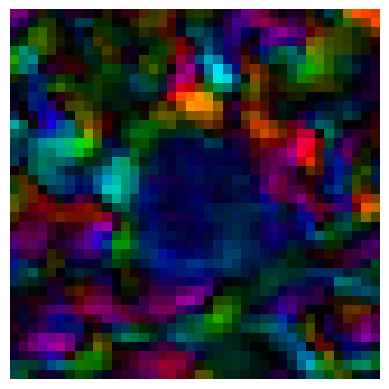

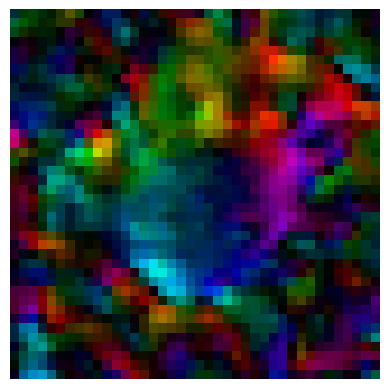

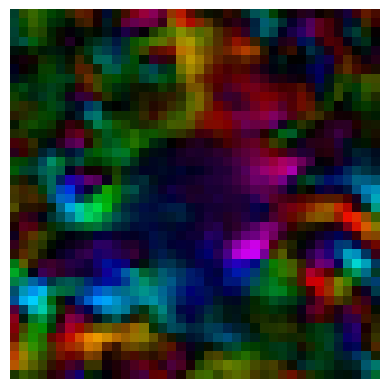

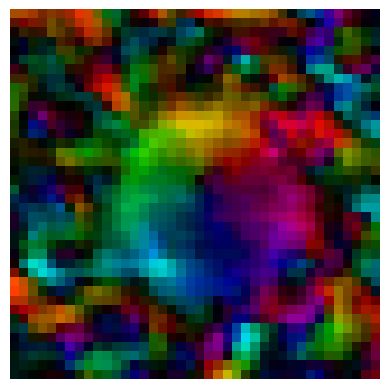

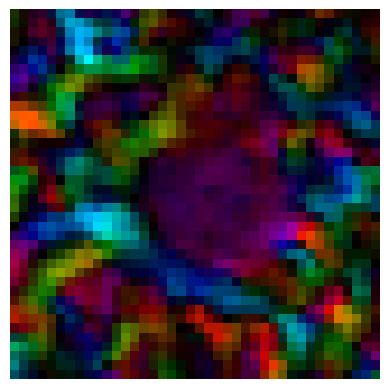

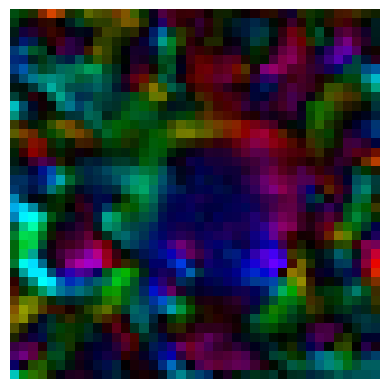

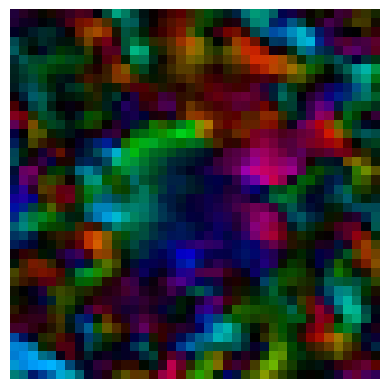

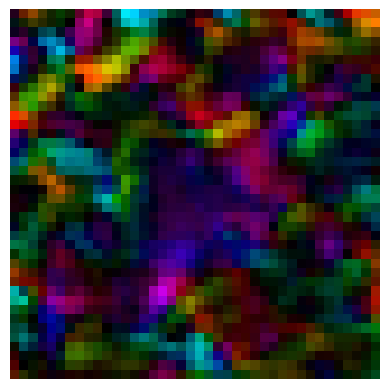

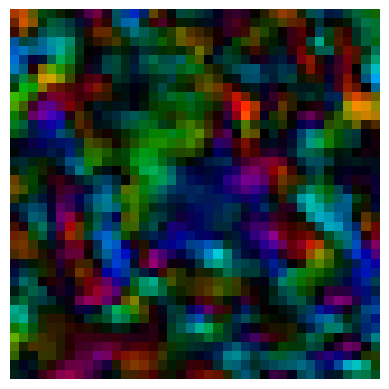

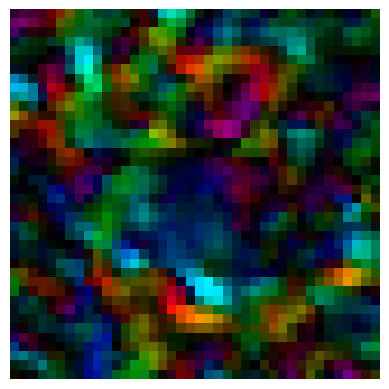

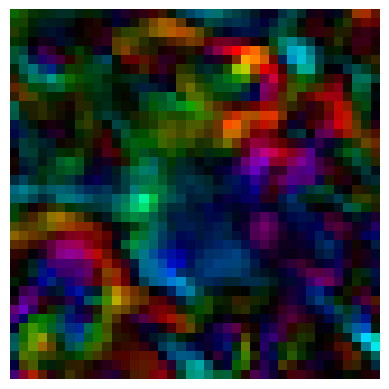

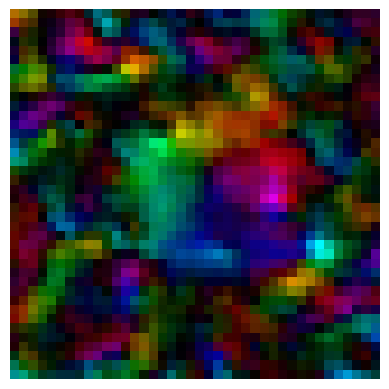

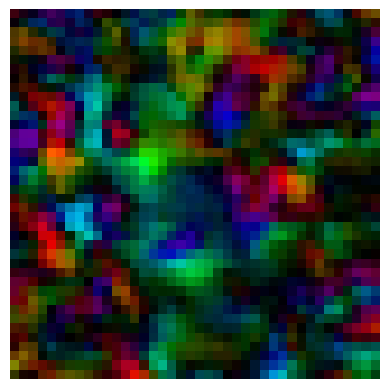

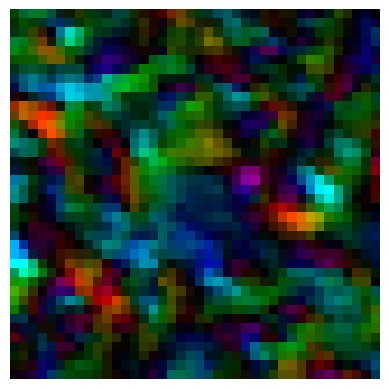

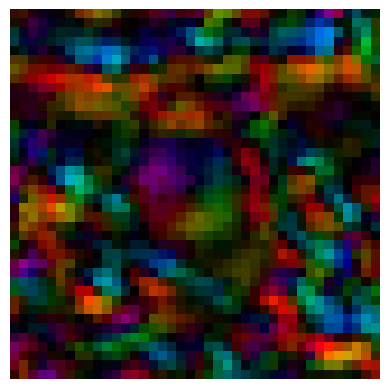

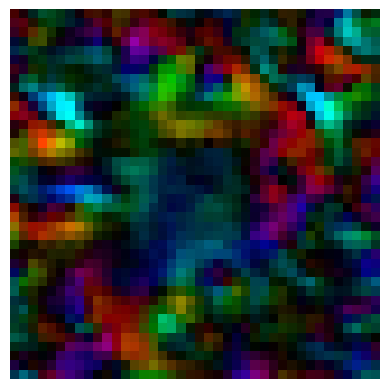

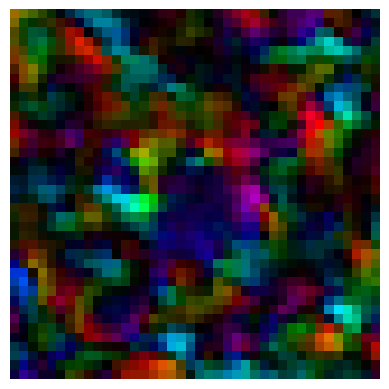

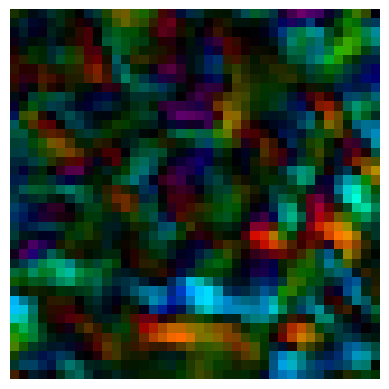

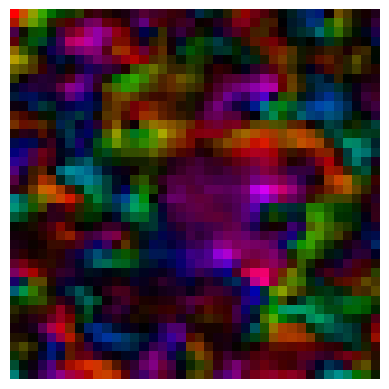

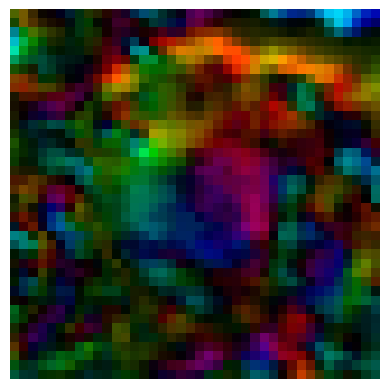

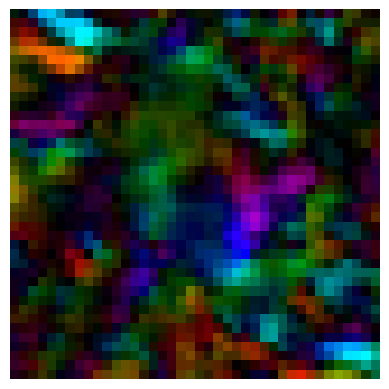

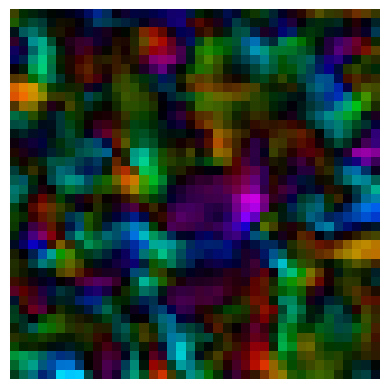

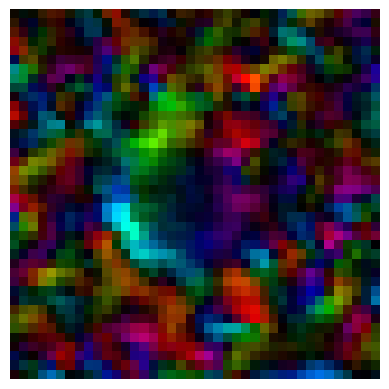

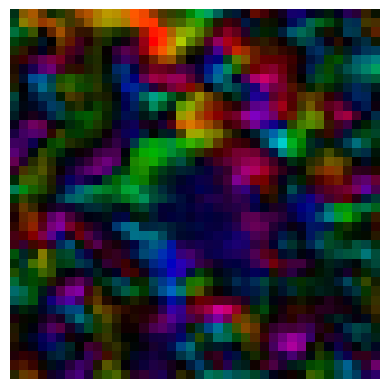

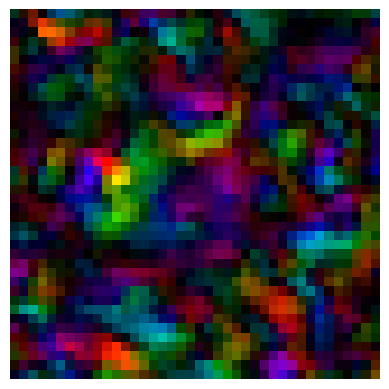

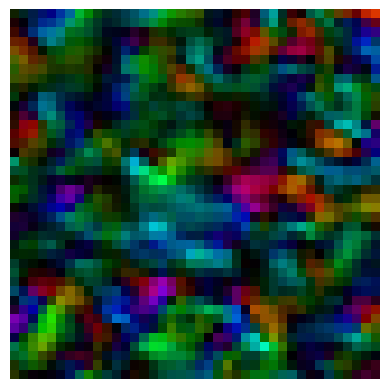

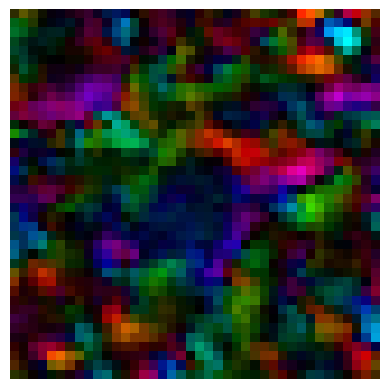

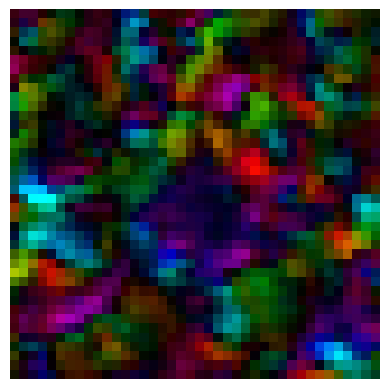

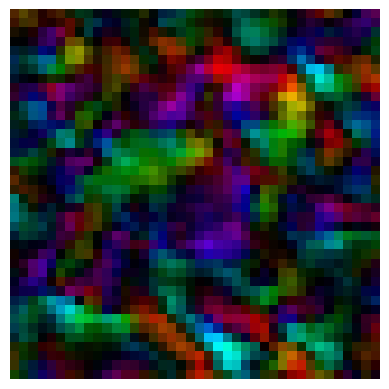

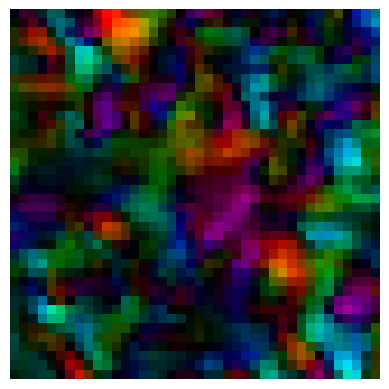

In [17]:
##### import numpy as np
import hyperspy.api as hs
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.ndimage import gaussian_filter
from collections import defaultdict
from pathlib import Path
import pyxem as pxm



SHOW_POSITIONS = False
MAGNETIC_DATA_FOLDER = Path("data/magnetic-data")

def find_center_of_mass(array):
    total_y = 0
    total_x = 0

    c = 2**5
    
    normalisation = np.sum(array/c)

    for y in range(array.shape[0]):
        for x in range(array.shape[1]):
            total_x += x*c*(array[y,x]/normalisation)
            total_y += y*c*(array[y,x]/normalisation)
            
    return np.array([round(total_x), round(total_y)])

def find_peaks(signal, limit=(1/3)):
    threshold = (np.max(signal))*limit
    peaks = []
    x0 = None

    
    for x in np.arange(signal.shape[0]):
        if (signal[x]) > threshold and x0==None:
            x0 = x

        if (signal[x]) < threshold and x0!=None:
            peaks.append(round((x+x0)/2))
            x0 = None
    return peaks

# Credit: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-mas
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()


def fit_gaussian(data, plot=False):
    # Create x and y indices
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    
    #create data
    initial_data = twoD_Gaussian((x, y), 2,int(data.shape[1]/2),int(data.shape[0]/2),5,5,0,1)
    
    # plot twoD_Gaussian data generated above
    #plt.figure()
    #plt.imshow(initial_data.reshape(data.shape[1]+1, data.shape[0]+1))
    #plt.colorbar()

    # add some noise to the data and try to fit the data generated beforehand
    initial_guess = (2,int(data.shape[1]/2),int(data.shape[0]/2),5,5,0,10)

    flatten_data = data.flatten()
    
    #data_noisy = initial_data + 0.2*np.random.normal(size=initial_data.shape)
    
    popt, pcov = curve_fit(twoD_Gaussian, (x, y), flatten_data, p0=initial_guess, maxfev = 5000)


    if plot:
        data_fitted = twoD_Gaussian((x, y), *popt)

        
        fig, ax = plt.subplots(1, 1)
        #ax.hold(True) For older versions. This has now been deprecated and later removed
        ax.imshow(flatten_data.reshape(data.shape[1], data.shape[0]), cmap=plt.cm.jet, origin='lower',
            extent=(x.min(), x.max(), y.min(), y.max()))
        ax.contour(x, y, data_fitted.reshape(data.shape[1], data.shape[0]), 8, colors='w')
        plt.show()
    
    return (popt[1]-data.shape[1]/2, popt[2]-data.shape[0]/2)



cap = defaultdict(lambda:0.87)
cap["005"] = 0.92
cap["017"] = 0.90


name_to_width = {
    "002": (220, 250),
    "003": (440, 500),
    "004": (320, 380),
    "005": (220, 250),
    "006": (160, 190),
    "007": (100, 130),
    "009": (440, 500),
    "010": (320, 380),
    "011": (200, 260),
    "012": (200, 260),
    "013": (220, 250),
    "014": (220, 250),
    "015": (160, 190),
    "016": (100, 130),
    "017": (100, 130),
}


os.makedirs(str(MAGNETIC_DATA_FOLDER), exist_ok=True)


for name in names_with_magnetism:
    s = hs.load(dm3[name])
    
    data = gaussian_filter(s.data, sigma=5)
    max_value = np.max(data)


    hist = np.histogram(data, bins=1000)
    hist_cumsum = np.cumsum(hist[0])
    threshold_index = np.argmax(hist_cumsum>cap[name]*np.size(data))
    threshold = hist[1][threshold_index]
    
    #threshold = max_value*cap[name]
    data[data < threshold] = 0
    data[data >= threshold] = max_value
    
    border = 35
    data[0:border, :] = 0
    data[-border:, :] = 0
    data[:, 0:border] = 0
    data[:, -border:] = 0
    
    
    
    
    signal_x = np.sum(data, axis=0)
    signal_y = np.sum(data, axis=1)

    print(f"Figures for {name}")

    debug = False
    if debug:
        fig, ax = plt.subplots()
        ax.imshow(data, cmap='gray')
        plt.show()
        
        fig, ax = plt.subplots()
        ax.plot(np.arange(len(signal_x)), signal_x)
        plt.show()
    
        fig, ax = plt.subplots()
        ax.plot(np.arange(len(signal_y)), signal_y)
        plt.show()
    
    
    peaks_x = find_peaks(signal_x)
    peaks_y = find_peaks(signal_y)

    if debug:
        print("peaks_x:", peaks_x)
        print("peaks_y:", peaks_y)
    
    
    subfigure_half_width = int(40/2)
    
    positions = []
    
    for y in peaks_y:
        for x in peaks_x:
            
            #for i in range(4):
            data_cutout = s.data[y-subfigure_half_width:y+subfigure_half_width, x-subfigure_half_width:x+subfigure_half_width]
            data_cutout_norm = np.sum(data_cutout)
    
            try:
                dx,dy = fit_gaussian(data_cutout/data_cutout_norm, plot=False)
            except RuntimeError as e:
                print("Error occured:", e)
                print("Position of error figure:", (x,y))
                fig, ax = plt.subplots()
                ax.imshow(data_cutout, cmap='gray')
                plt.show()
                    
            positions.append((x+int(dx),y+int(dy)))
    
            if False:
                data_cutout = s.data[y+int(dy)-subfigure_half_width:y+int(dy)+subfigure_half_width, x+int(dx)-subfigure_half_width:x+int(dx)+subfigure_half_width]
                fig, ax = plt.subplots()
                circle = patches.Circle((subfigure_half_width, subfigure_half_width), 1)
                
                ax.imshow(data_cutout, cmap='gray')
                ax.add_patch(circle)
                plt.show()

    assert len(positions)==24, f"Found {len(positions)} subfigures instead of 24 at figure {name}"
    
    if SHOW_POSITIONS:
        fig, ax = plt.subplots()
        ax.imshow(s.data, cmap='gray')
        
        width = 38
        for (x,y) in positions:
            square = patches.Rectangle((x-int(width/2), y-int(width/2)), width, width, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(square)
    
        plt.show()

    magnetic_data = get_magnetic_data(name)
    x, y = subfigure_half_width + 1, subfigure_half_width + 1
    magnetic_data_slice = magnetic_data.inav[y-subfigure_half_width:y+subfigure_half_width, x-subfigure_half_width:x+subfigure_half_width]

    magnetic_direction_path = MAGNETIC_DATA_FOLDER.joinpath("_magnetic-direction.png")

    if not magnetic_direction_path.is_file():
        magnetic_data_slice.data = np.zeros((subfigure_half_width*2, subfigure_half_width*2, 2))
        ax_indicator = fig.add_subplot(2, 2, 1)
        fig, ax = plt.subplots()
        pxm.utils.plotting.plot_beam_shift_color(magnetic_data_slice, ax=ax, ax_indicator=ax_indicator)
        fig.savefig(str(magnetic_direction_path))

    
    pixel_size = magnetic_data.axes_manager[0].size
    
    for i, (x,y) in enumerate(positions):
        x_index = i%4
        y_index = int((i-x_index)/4)

        fig, ax = plt.subplots()
        subfigure_name = f"{name}-{str(i).zfill(2)}"
        file_basename = MAGNETIC_DATA_FOLDER.joinpath(subfigure_name)

        #print(f"slice values:{y-subfigure_half_width}:{y+subfigure_half_width}---{x-subfigure_half_width}:{x+subfigure_half_width}")
        magnetic_data_slice.data = magnetic_data.data[y-subfigure_half_width:y+subfigure_half_width, x-subfigure_half_width:x+subfigure_half_width]

        ax_indicator = False
        pxm.utils.plotting.plot_beam_shift_color(magnetic_data_slice, ax=ax, ax_indicator=ax_indicator)

        fig.savefig(str(file_basename.with_suffix(".png")))

        if x_index == 0 or x_index==1:
            width_nm = name_to_width[name][0]
        else:
            width_nm = name_to_width[name][1]


        squircle = Squircle(figure_name=name, index=i, squircle_factor=y_index, data=magnetic_data_slice.data, pixel_size=magnetic_data_slice.axes_manager[0].scale, width_nm=width_nm)
        squircle.serialize(str(file_basename))

In [20]:
import shutil

shutil.make_archive("squircles", 'zip', str(MAGNETIC_DATA_FOLDER))

'/cluster/home/christgy/projects/nanotools-magnetic-domain-analysis/squircles.zip'